In [1]:
#importing necessary libraries
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
    from torchvision.models import resnet50, ResNet50_Weights
    from torchvision import transforms
except ModuleNotFoundError as e:
    raise ImportError("Missing PyTorch or torchvision. Please install them using `pip install torch torchvision`. Error: {}".format(e))

from datasets import load_dataset
from itertools import islice
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from huggingface_hub import login
import torch.optim as optim
import requests

c:\Users\spothapragada\Miniconda3\envs\ood_stuff\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#hugging face login
login(token="hf_XXX")

In [3]:
# Load Pretrained Model


weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
# Hook for capturing activations and gradients

class LayerHook:
    def __init__(self, layer):
        self.activations = None
        self.gradients = None
        self.hook_f = layer.register_forward_hook(self.forward_hook)
        self.hook_b = layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output.detach()

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def close(self):
        self.hook_f.remove()
        self.hook_b.remove()

# Register hooks
layer_names = ['layer3', 'layer4']
hooks = {}
for name, module in model.named_modules():
    if name in layer_names:
        hooks[name] = LayerHook(module)

In [5]:
#  Load ImageNet & Cifar10 datasets


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

imagenet_streamed = load_dataset("imagenet-1k", split="validation", streaming=True)
subset = list(islice(imagenet_streamed, 1000))
imgnet_images = [example['image'] for example in subset]
imgnet_labels = [example['label'] for example in subset]

# svhn = load_dataset("ufldl-stanford/svhn", "full_numbers")
# svhn_images = svhn['test']['image']
# svhn_labels = svhn['test']['digits']
cifar=load_dataset("cifar10", split="test")
cifar_images = cifar['img']
cifar_labels = cifar['label']

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)
        img = img.convert("RGB")

        return self.transform(img), label

in_loader = DataLoader(CustomImageDataset(imgnet_images, imgnet_labels, preprocess), batch_size=16)
ood_loader = DataLoader(CustomImageDataset(cifar_images, cifar_labels, preprocess), batch_size=16)

In [6]:
# Compute GAIN (Gradient x Activation)
#I have only consider a single pass to detect important neurons, this can be changed to running several images and taking an average of all samples to get to importnt neurons


x_batch, y_batch = next(iter(in_loader))
x_batch.requires_grad = True
outputs = model(x_batch)
loss = F.cross_entropy(outputs, y_batch)
loss.backward()

def compute_gain_scores(hooks):
    gain_scores = {}
    for name, hook in hooks.items():
        act = hook.activations
        grad = hook.gradients
        if act.dim() > 2:
            act = act.view(act.size(0), act.size(1), -1).mean(dim=2)
            grad = grad.view(grad.size(0), grad.size(1), -1).mean(dim=2)
        gain = (act * grad).detach()
        gain_scores[name] = gain
    return gain_scores

gain_scores = compute_gain_scores(hooks)

important_neurons = {}
for name, gains in gain_scores.items():
    avg_gain = gains.mean(dim=0)
    topk = torch.topk(avg_gain, k=2)
    important_neurons[name] = topk.indices

c:\Users\spothapragada\Miniconda3\envs\ood_stuff\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [7]:
# Activation Extraction
# After getting important neurons, we extract activations from in distribution and out distributions and compute OOD scores

def collect_neuron_activations(dataloader, model, hooks, important_neurons):
    activations = {layer: [] for layer in important_neurons}
    with torch.no_grad():
        for x, _ in dataloader:
            _ = model(x)
            for name, indices in important_neurons.items():
                act = hooks[name].activations
                if act.dim() > 2:
                    act = act.view(act.size(0), act.size(1), -1).mean(dim=2)
                selected = act[:, indices]
                activations[name].append(selected.cpu())
    for name in activations:
        activations[name] = torch.cat(activations[name], dim=0)
    return activations

in_acts = collect_neuron_activations(in_loader, model, hooks, important_neurons)
ood_acts = collect_neuron_activations(ood_loader, model, hooks, important_neurons)

#  OOD Scoring


def compute_ood_scores(in_acts, ood_acts):
    scores = []
    for layer in in_acts:
        in_mean = in_acts[layer].mean(dim=0, keepdim=True)
        dists = F.pairwise_distance(ood_acts[layer], in_mean)
        scores.append(dists.unsqueeze(1))
    return torch.cat(scores, dim=1).mean(dim=1)

ood_scores = compute_ood_scores(in_acts, ood_acts)
in_scores = compute_ood_scores(in_acts, in_acts)

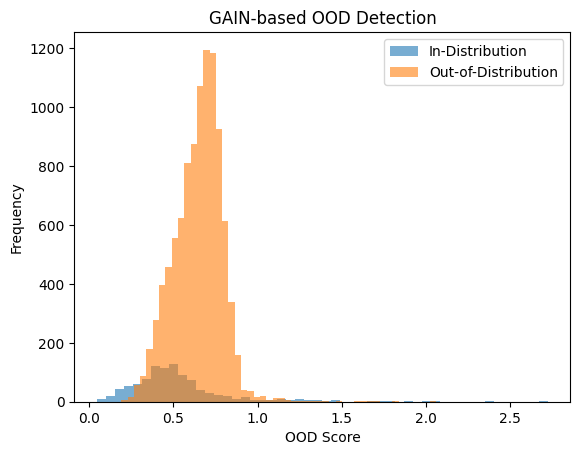

In [8]:
# Plotting


plt.hist(in_scores.numpy(), bins=50, alpha=0.6, label='In-Distribution')
plt.hist(ood_scores.numpy(), bins=50, alpha=0.6, label='Out-of-Distribution')
plt.xlabel('OOD Score')
plt.ylabel('Frequency')
plt.legend()
plt.title("GAIN-based OOD Detection")
plt.show()

# Cleanup hooks
for hook in hooks.values():
    hook.close()